In [1]:
import requests
from urllib.parse import urlencode
from creds import cid, secret
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Authorization URL
auth_url = 'https://accounts.spotify.com/authorize'

# Redirect URI (ensure this matches in your Spotify Developer Dashboard)
redirect_uri = 'https://example.com/callback'

# Set the scope of permissions
scope = 'user-top-read user-read-recently-played'

# Create the authorization URL
auth_params = {
    'client_id': cid,
    'response_type': 'code',
    'redirect_uri': redirect_uri,
    'scope': scope
}

auth_url = f"{auth_url}?{urlencode(auth_params)}"
print(f"1. Visit this URL in your browser: {auth_url}")
print("2. Authorize the application.")
print("3. After authorizing, you'll be redirected to a URL starting with https://example.com/callback")
print("4. Copy the entire URL you're redirected to.")
print("5. Run the next cell when you're ready to input the redirect URL.")

1. Visit this URL in your browser: https://accounts.spotify.com/authorize?client_id=5e6fa06773d94f1aac1b0ddb386f638a&response_type=code&redirect_uri=https%3A%2F%2Fexample.com%2Fcallback&scope=user-top-read+user-read-recently-played
2. Authorize the application.
3. After authorizing, you'll be redirected to a URL starting with https://example.com/callback
4. Copy the entire URL you're redirected to.
5. Run the next cell when you're ready to input the redirect URL.


In [2]:
redirect_url = input("Paste the entire redirect URL here: ")

code = redirect_url.split('code=')[1].split('&')[0]

# Exchange the code for an access token
token_url = 'https://accounts.spotify.com/api/token'
token_data = {
    'grant_type': 'authorization_code',
    'code': code,
    'redirect_uri': redirect_uri,
    'client_id': cid,
    'client_secret': secret
}

r = requests.post(token_url, data=token_data)
token_info = r.json()
access_token = token_info['access_token']

print("Access token obtained successfully!")

Access token obtained successfully!


In [3]:
top_tracks_url = 'https://api.spotify.com/v1/me/top/tracks'
headers = {
    'Authorization': f'Bearer {access_token}'
}
params = {
    'time_range': 'medium_term',
    'limit': 50
}

r = requests.get(top_tracks_url, headers=headers, params=params)

if r.status_code == 200:
    tracks = r.json()['items']
    print("Your top 10 tracks:")
    for i, track in enumerate(tracks, 1):
        print(f"{i}. {track['name']} by {track['artists'][0]['name']}")
else:
    print(f"Failed to retrieve top tracks. Status code: {r.status_code}")
    print(f"Error message: {r.text}")

Your top 10 tracks:
1. For The Moment by Augustine
2. Heading For The Door - SiriusXM Session by Royel Otis
3. Renaissance by Angara
4. Elenore - Sonnee Remix by Sultan + Shepard
5. Starting Every Day by Cuatro Cuatro Cero
6. Woman by Augustine
7. One Bad Day by Spacey Jane
8. En by Sultan + Shepard
9. Linger - SiriusXM Session by Royel Otis
10. Glasses by Northwest Stories
11. Murder on the Dance Floor - triple j Like A Version by Royel Otis
12. Astray (Tritonia 459) - CRi Remix by CRi
13. Sirens (feat. Caroline Polachek) [Tourist Remix] by Flume
14. Nothing New by The Strike
15. Bull Breed by Royel Otis
16. The Flood by Lane 8
17. I'll Be Here by Sultan + Shepard
18. Heading For The Door by Royel Otis
19. Facts 2.0 by AV AV AV
20. I Don't Mind - Robby East Remix by Le Youth
21. Yes Yes by The Colourist
22. Dream About You by Kasablanca
23. Other Side by Stockholm Worship
24. Claw Foot by Royel Otis
25. Molly by Royel Otis
26. Coast by Augustine
27. Answers - Extended Version by Corne

In [14]:

# Fetch audio features for top tracks
track_ids = [track['id'] for track in tracks]
audio_features_url = f"https://api.spotify.com/v1/audio-features?ids={','.join(track_ids)}"

r = requests.get(audio_features_url, headers=headers)
audio_features = r.json()['audio_features']

# Create a DataFrame with track names and audio features
df = pd.DataFrame({
    'name': [track['name'] for track in tracks],
    'artist': [track['artists'][0]['name'] for track in tracks],
    **{feature: [track[feature] for track in audio_features] for feature in 
       [
           'acousticness',
           'danceability', 
           'duration_ms',
           'energy', 
           'tempo',
           'instrumentalness', 
           'key', 
           'liveness', 
           'loudness', 
           'mode', 
           'speechiness', 
           'time_signature', 
           'valence', 
       ]}
})



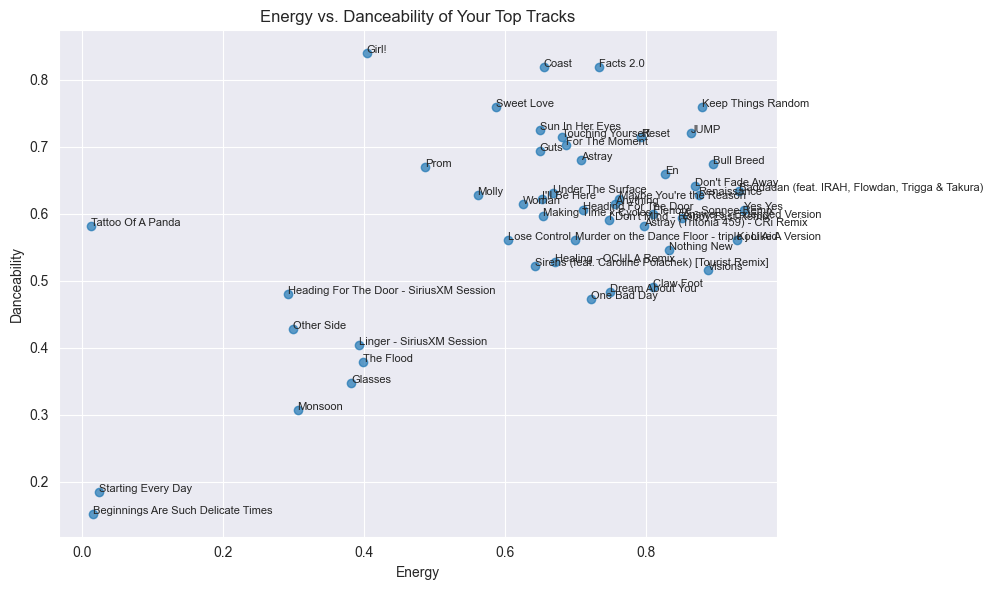

In [15]:
# Create a scatter plot of energy vs. danceability
plt.figure(figsize=(10, 6))
plt.scatter(df['energy'], df['danceability'], alpha=0.7)
for i, txt in enumerate(df['name']):
    plt.annotate(txt, (df['energy'][i], df['danceability'][i]), fontsize=8)
plt.xlabel('Energy')
plt.ylabel('Danceability')
plt.title('Energy vs. Danceability of Your Top Tracks')
plt.tight_layout()
plt.show()

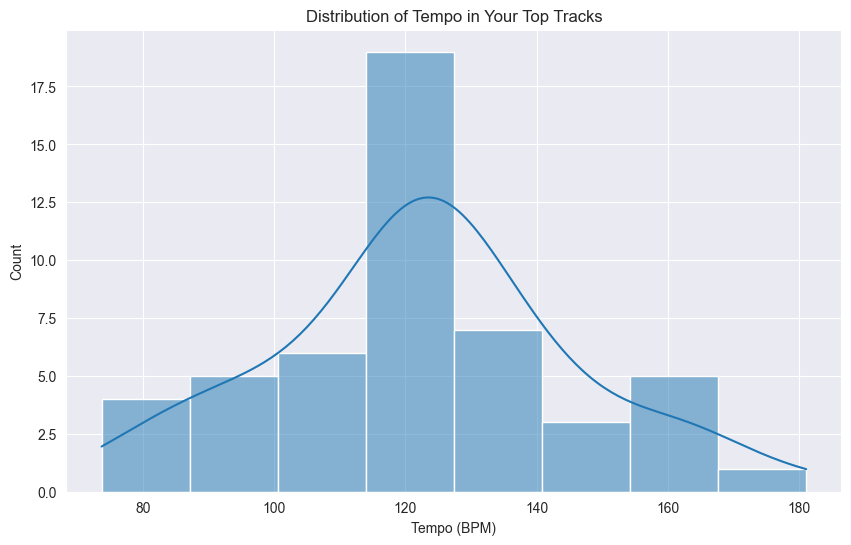

In [16]:
# Tempo Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['tempo'], kde=True)
plt.title('Distribution of Tempo in Your Top Tracks')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Count')
plt.show()

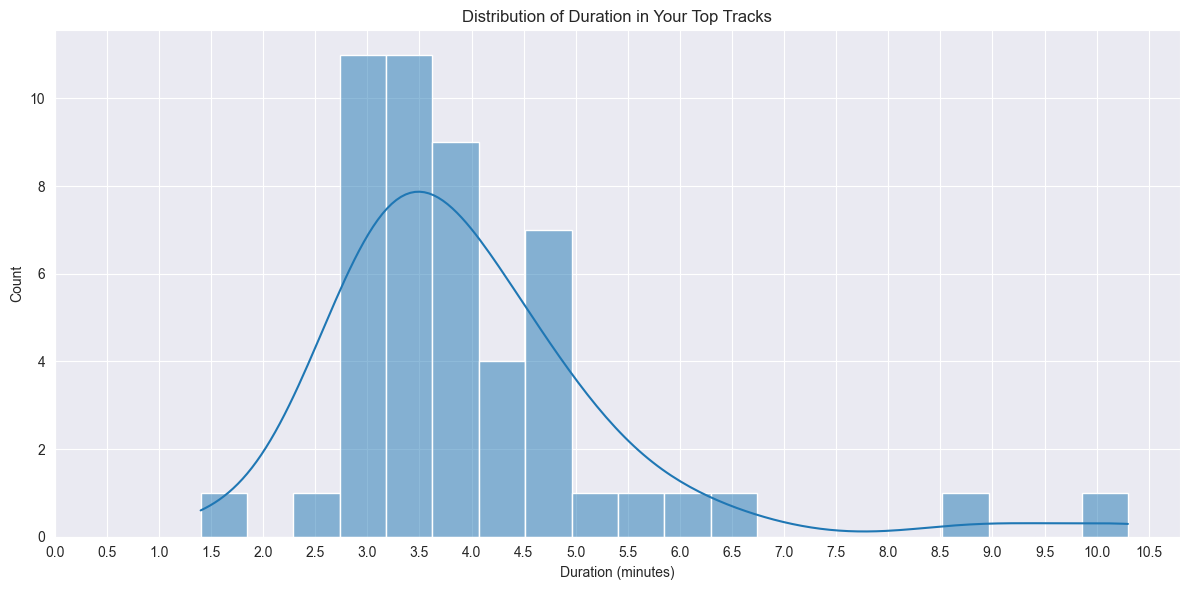

In [23]:
# Convert duration from ms to minutes and round to 1 decimal place
df['duration_min'] = round(df['duration_ms'] / 60000, 1)

plt.figure(figsize=(12, 6))
sns.histplot(df['duration_min'], kde=True, bins=20)
plt.title('Distribution of Duration in Your Top Tracks')
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')

# Set x-axis ticks to 0.5 minute increments
max_duration = df['duration_min'].max()
x_ticks = np.arange(0, max_duration + 0.5, 0.5)
plt.xticks(x_ticks)

# Adjust x-axis limit to include the full range
plt.xlim(0, max_duration + 0.5)

plt.tight_layout()
plt.show()

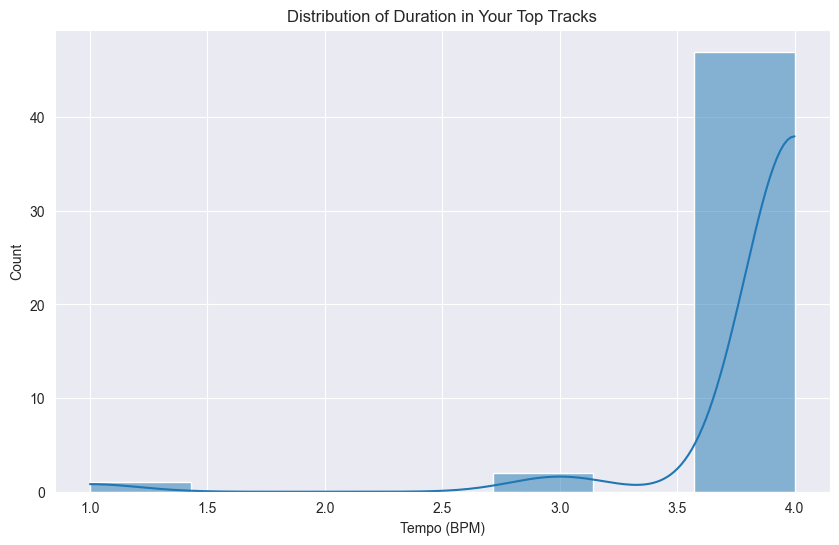

In [22]:
# Duration Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['time_signature'], kde=True)
plt.title('Distribution of Duration in Your Top Tracks')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Count')
plt.show()

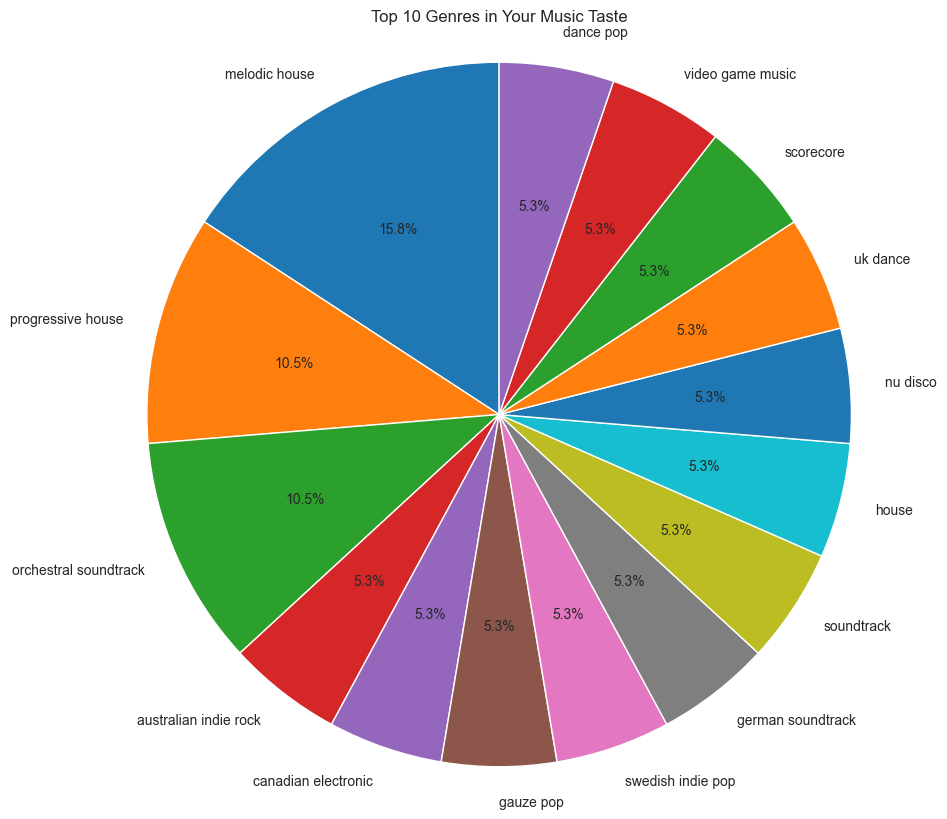

In [18]:
# Top Artists Analysis
top_artists_url = 'https://api.spotify.com/v1/me/top/artists'
r = requests.get(top_artists_url, headers=headers, params={'limit': 10})
top_artists = r.json()['items']

artist_df = pd.DataFrame({
    'name': [artist['name'] for artist in top_artists],
    'popularity': [artist['popularity'] for artist in top_artists],
    'followers': [artist['followers']['total'] for artist in top_artists]
})

# 4. Genre Analysis
genres = [genre for artist in top_artists for genre in artist['genres']]
genre_counts = pd.Series(genres).value_counts().head(20)

plt.figure(figsize=(10, 10))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Top 10 Genres in Your Music Taste')
plt.axis('equal')
plt.show()

In [24]:
df.head()

,name,artist,acousticness,danceability,duration_ms,energy,tempo,instrumentalness,key,liveness,loudness,mode,speechiness,time_signature,valence,duration_min
0,For The Moment,Augustine,0.3490,0.703,197468,0.6860,87.006,0.1660,10,0.0778,-4.944,1,0.0306,4,0.6290,3.3
1,Heading For The Door - SiriusXM Session,Royel Otis,0.9880,0.480,204667,0.2930,162.841,0.0601,1,0.1140,-11.072,1,0.0372,4,0.1900,3.4
2,Renaissance,Angara,0.0281,0.627,283548,0.8740,124.001,0.7430,8,0.0881,-7.753,1,0.0467,4,0.3510,4.7
3,Elenore - Sonnee Remix,Sultan + Shepard,0.1100,0.600,230796,0.8090,125.005,0.8180,7,0.1890,-8.459,1,0.0544,4,0.0378,3.8
4,Starting Every Day,Cuatro Cuatro Cero,0.9870,0.185,619355,0.0244,73.671,0.9440,8,0.0662,-32.576,1,0.0417,4,0.0380,10.3
